# Download and Unzip Function

To see the download and unzipping progress

In [1]:
!pip install lemma-dev-utils
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for lemma-dev-utils: filename=lemma_dev_utils-0.0.3-py3-none-any.whl size=4916 sha256=3911569789eb40492ae24d9b3ea16151ab7f232fe6ef908ab990c4a94abcb523
  Stored in directory: /root/.cache/pip/wheels/18/10/d6/61f6e972fad08c7ffc400e9429eaaf3b511773d7a71cd5b6e7
Successfully built lemma-dev-utils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 44 kB/s 
     |████████████████████████████████| 199 kB 45.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=6d96f6ea653b126764e0e2cf0092ea116883df7de9abac65be86a889bf1a7818
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


# Downloading the Dataset

In [ ]:
with open('dataset_url.txt', 'r') as f:
    url = f.read()

In [ ]:
from lemma_dev_utils import download_unzip
import os

path = 'dataset'

download_unzip(path, url)
os.chdir(path)

Unzipping train_labels.csv: 100%|##########| 30752769/30752769 [00:00<00:00, 71092381.31it/s]


# Setting up Spark

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/Shareddrives/Mie Robe')

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
        
sc = spark.sparkContext

# Libraries

In [6]:
import itertools
import numpy as np
import seaborn as sns
import re
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report as cr
from collections import Counter
from pyspark.sql.functions import variance
from pyspark.sql.functions import col, when
from pyspark.ml.functions import vector_to_array
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.feature import VarianceThresholdSelector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Loading the Training Set

In [7]:
raw_data = sc.textFile("train_data.csv")
raw_labels = sc.textFile("train_labels.csv")

# Preprocessing



## Managing Numeric and NaN values

In [8]:
def isnumeric_val(val):
    non_negative = val.replace("-", "", 1)
    non_decimal = non_negative.replace(".", "", 1)
    non_scientific = non_decimal.replace("e-", "", 1).replace("e", "", 1)
    isitnumeric = non_scientific.isdigit()
    return isitnumeric

def clean_split_csv(row):
    # Split Row
    split_row = row.split(',')
    new_row = list()

    for val in split_row:
        # Fill NaN
        val = val if val != '' else '0.0'
        # Rounding numbers
        val_toadd = math.floor(float(val)*1000)/1000 if isnumeric_val(val) else val
        new_row.append(val_toadd)

    return tuple(new_row)

## Getting features, labels and the header

In [9]:
# cleaning the training data
clean_data = raw_data.map(lambda row: clean_split_csv(row))
header_features = clean_data.take(1)[0]
features = clean_data.filter(lambda x: x != header_features)

# cleaning the training labels
clean_labels = raw_labels.map(lambda row: clean_split_csv(row))
header_labels = clean_labels.take(1)[0]
labels = clean_labels.filter(lambda x: x != header_labels)

## Sampling the dataset

In [ ]:
# sampled_data = features.sample(withReplacement = False, fraction = 0.1, seed = 42)

In [10]:
sampled_data = features

## Get number of partitions I have

In [ ]:
sampled_data.getNumPartitions()

2

# From RDD to DF

In [ ]:
# %%time
# # around 26 minutes
# df = sampled_data.toDF(header_features)
# df_schema = df.schema
# df.write.csv("sample_train_data_(spark).csv")
# del df

In [ ]:
# df = spark.read.format("csv") \
#     .option("header", True) \
#     .schema(df_schema) \
#     .load("sample_train_data_(spark).csv")

In [11]:
df = sampled_data.toDF(header_features)

In [12]:
df.rdd.getNumPartitions()

2

## Checking column names

In [13]:
df_columns = df.columns
len(header_features) == len(df_columns)

True

In [14]:
header_features == tuple(df_columns)

True

In [15]:
header_features[:5], df_columns[:5]

(('customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'),
 ['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1'])

## Rename with original column names

## Looking at the dataset shape and schema

In [16]:
df.show()

+--------------------+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+------+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+-----+----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----

In [17]:
schema = {col.name : str(col.dataType) for col in df.schema}
print(*[f"{x}\n" for x in schema.items() if x[1] != 'DoubleType()'])

('customer_ID', 'StringType()')
 ('S_2', 'StringType()')
 ('D_63', 'StringType()')
 ('D_64', 'StringType()')



In [18]:
n_rows = df.count()
n_columns = len(df_columns)
print(f"n° o Rows: {n_rows}")
print(f"n° o Columns: {n_columns}")

n° o Rows: 10001
n° o Columns: 190


In [ ]:
df.printSchema()

root
 |-- customer_ID: string (nullable = true)
 |-- S_2: string (nullable = true)
 |-- P_2: double (nullable = true)
 |-- D_39: double (nullable = true)
 |-- B_1: double (nullable = true)
 |-- B_2: double (nullable = true)
 |-- R_1: double (nullable = true)
 |-- S_3: double (nullable = true)
 |-- D_41: double (nullable = true)
 |-- B_3: double (nullable = true)
 |-- D_42: double (nullable = true)
 |-- D_43: double (nullable = true)
 |-- D_44: double (nullable = true)
 |-- B_4: double (nullable = true)
 |-- D_45: double (nullable = true)
 |-- B_5: double (nullable = true)
 |-- R_2: double (nullable = true)
 |-- D_46: double (nullable = true)
 |-- D_47: double (nullable = true)
 |-- D_48: double (nullable = true)
 |-- D_49: double (nullable = true)
 |-- B_6: double (nullable = true)
 |-- B_7: double (nullable = true)
 |-- B_8: double (nullable = true)
 |-- D_50: double (nullable = true)
 |-- D_51: double (nullable = true)
 |-- B_9: double (nullable = true)
 |-- R_3: double (nullable = t

In [19]:
# input from American Express challenge
categorical_variables = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [20]:
categorical_df = df.select(categorical_variables)

In [21]:
categorical_df.show()

+----+----+-----+-----+-----+-----+-----+----+----+----+----+
|B_30|B_38|D_114|D_116|D_117|D_120|D_126|D_63|D_64|D_66|D_68|
+----+----+-----+-----+-----+-----+-----+----+----+----+----+
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0|  1.0|  CL|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  2.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 2.0|  1.0|  0.0|  3.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 0.0| 1.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 1.0|  0.0|  0.0| -1.0|  0.0|  1.0|  CR|   O| 0.0| 6.0|
| 1.0| 4.0|  1.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 6.0|
| 0.0| 3.0|  0.0|  0.0|  2.0|  0.0|  0.0|  CL|   U| 0.0| 2.0|
| 0.0| 2.0|  1.0|  0.0|  6.0|  0.0|  0.0|  CR|   O| 0.0| 5.0|
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0| -1.0|  CR|   O| 0.0| 5.0|
| 0.0| 1.0|  0.0|  0.0|  4.0|  0.0|  1.0|  CO|   O| 0.0| 5.0|
| 0.0| 1.0|  1.0|  0.0|  4.0|  0.0|  0.0|  CO|   O| 0.0| 6.0|
| 0.0| 2.0|  0.0|  0.0|  3.0|  0.0|  1.0|  CO|   R| 0.0| 5.0|
| 0.0| 7.0|  0.0|  0.0|  4.0|  0.0|  0.0|  CO|   U| 0.0| 4.0|
| 0.0| 2

In [ ]:
categorical_df.describe().show()

+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|summary|               B_30|              B_38|              D_114|               D_116|             D_117|              D_120|             D_126| D_63|                D_64|               D_66|              D_68|
+-------+-------------------+------------------+-------------------+--------------------+------------------+-------------------+------------------+-----+--------------------+-------------------+------------------+
|  count|              10001|             10001|              10001|               10001|             10001|              10001|             10001|10001|               10001|              10001|             10001|
|   mean|0.15828417158284172| 2.719128087191281|  0.593040695930407|0.001599840015998...|2.2386761323867614|0.11078892110788921|0.72262773722627

In [ ]:
categorical_df.describe().filter("summary = 'max'").collect()

[Row(summary='max', B_30='2.0', B_38='7.0', D_114='1.0', D_116='1.0', D_117='6.0', D_120='1.0', D_126='1.0', D_63='XZ', D_64='U', D_66='1.0', D_68='6.0')]

In [ ]:
categorical_df.describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='-1.0', D_120='0.0', D_126='-1.0', D_63='CL', D_64='-1.0', D_66='0.0', D_68='0.0')]

D_117 and D_126 may be a problem as they were known values but we changed the nan values to 0, they have negative values I'll make them 0.5 to adjust to a category semantically closer to the original one

# Fixing the negative values appearing in the categories

In [22]:
for i in ['D_117', 'D_126', 'D_64']:
    df = df.withColumn(i, when((col(i) == -1.0), 0.5).otherwise(col(i)))

In [ ]:
df.select(categorical_variables).describe().filter("summary = 'min'").collect()

[Row(summary='min', B_30='0.0', B_38='0.0', D_114='0.0', D_116='0.0', D_117='0.0', D_120='0.0', D_126='0.0', D_63='CL', D_64='0.0', D_66='0.0', D_68='0.0')]

# Casting string-type categories to numeric
As per the request of Spark

In [23]:
new_categorical_variables = [f'{col}_numeric' for col in categorical_variables]
indexer = StringIndexer(inputCols=categorical_variables, outputCols=new_categorical_variables).fit(df)
df = indexer.transform(df)

In [24]:
categorical_df = df.select(categorical_variables+new_categorical_variables)

In [ ]:
categorical_df.groupby(['B_38_numeric', 'B_38']).count().show()

+------------+----+-----+
|B_38_numeric|B_38|count|
+------------+----+-----+
|         3.0| 5.0|  827|
|         6.0| 6.0|  277|
|         4.0| 4.0|  512|
|         7.0| 0.0|    4|
|         2.0| 1.0| 2032|
|         1.0| 3.0| 2344|
|         0.0| 2.0| 3550|
|         5.0| 7.0|  455|
+------------+----+-----+



In [ ]:
categorical_df.groupby(['D_63_numeric', 'D_63']).count().show()

+------------+----+-----+
|D_63_numeric|D_63|count|
+------------+----+-----+
|         3.0|  XZ|   46|
|         5.0|  XL|    9|
|         4.0|  XM|   16|
|         0.0|  CO| 7451|
|         2.0|  CL|  753|
|         1.0|  CR| 1726|
+------------+----+-----+



In [25]:
# somewhat a heavy operation (it could be avoided) but I prefer to keep the original category labels
reverse_dictionary = {col : dict(categorical_df.groupby([f'{col}_numeric', col]).count()\
                                 .drop('count').collect()) for col in categorical_variables}

reverse_dictionary['D_63']

{3.0: 'XZ', 5.0: 'XL', 4.0: 'XM', 0.0: 'CO', 2.0: 'CL', 1.0: 'CR'}

In [26]:
reverse_dictionary.keys()

dict_keys(['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'])

In [27]:
# dropping old columns from dataframe
df = df.drop(*categorical_variables)

# One hot encoding Categorical variables

In [28]:
output_col_names = [f'{col}_enc' for col in categorical_variables]
encoder = OneHotEncoder(inputCols = new_categorical_variables, 
                        outputCols = output_col_names)

model = encoder.fit(df)
df = model.transform(df)

# dropping the numeric columns from df
df = df.drop(*new_categorical_variables)

df.select(output_col_names).show()

+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|     B_30_enc|     B_38_enc|    D_114_enc|    D_116_enc|    D_117_enc|    D_120_enc|    D_126_enc|     D_63_enc|     D_64_enc|     D_66_enc|     D_68_enc|
+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|(2,[0],[1.0])|(7,[0],[1.0])|    (1,[],[])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[2],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[3],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[0],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[0],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[1],[1.0])|(1,[0],[1.0])|(2,[0],[1.0])|(5,[1],[1.0])|(4,[0],[1.0])|(1,[0],[1.0])|(6,[0],[1.0])|
|(2,[0],[1.0])|(7,[2],[1.0])|(1,[0],[1.0])|(1,[0],[1.0])|(7,[2],

In [29]:
# renaming back columns to original names
for encoded_name, original_name in zip(output_col_names, categorical_variables):
    df = df.withColumnRenamed(encoded_name, original_name)

# Getting the Labels to Join them

In [30]:
label_df = labels.toDF()
label_cols = label_df.columns
for label_wrong_col, label_correct_col in zip(label_cols, header_labels):
    label_df = label_df.withColumnRenamed(label_wrong_col, label_correct_col)
label_df.show()

+--------------------+------+
|         customer_ID|target|
+--------------------+------+
|0000099d6bd597052...|   0.0|
|00000fd6641609c6e...|   0.0|
|00001b22f846c82c5...|   0.0|
|000041bdba6ecadd8...|   0.0|
|00007889e4fcd2614...|   0.0|
|000084e5023181993...|   0.0|
|000098081fde4fd64...|   0.0|
|0000d17a1447b25a0...|   0.0|
|0000f99513770170a...|   1.0|
|00013181a0c5fc8f1...|   1.0|
|0001337ded4e1c253...|   1.0|
|00013c6e1cec7c21b...|   1.0|
|0001812036f155833...|   1.0|
|00018dd4932409baf...|   0.0|
|000198b3dc70edd65...|   0.0|
|000201146e53cacdd...|   0.0|
|0002d381bdd8048d7...|   0.0|
|0002e335892f7998f...|   1.0|
|00031e8be98bc3411...|   0.0|
|000333075fb8ec6d5...|   1.0|
+--------------------+------+
only showing top 20 rows



In [31]:
df = df.join(label_df, ['customer_ID'])

In [32]:
columns_final = ['customer_ID', 'S_2', 'target']
feature_to_assemble = [col for col in header_features if col not in columns_final]

vecAssembler = VectorAssembler(inputCols=feature_to_assemble, 
                               outputCol="features")

assembled_df = vecAssembler.transform(df).select(columns_final+['features'])

In [ ]:
assembled_df.show()

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|            features|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|
|0033da35db3a15c28...|2017-08-29|   1.0|[0.273,0.384,0.02...|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.323,0.006,0.00...|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|
|005c74962a7c912f9...|2017-11-10|   1.0|[0.473,0.03,0.675...|
|005f7ccc9c4131b73...|2018-02-28|   0.0|[0.891,0.003,0.00...|
|006078e5943de3f1f...|2017-09-26|   0.0|[0.966,0.002,0.00...|
|00675c719a9666275...|2017-03-06|   0.0|[0.94,0.006,0.072...|
|0081622

# Feature Selection with Variance Threshold

In this section we will explore different classifiers using, as Feature selection, the *Variance Threshold* method.

In [33]:
selector_variance = VarianceThresholdSelector(varianceThreshold=0.5, outputCol="selectedFeatures")
model_variance = selector_variance.fit(assembled_df)

In [34]:
model_variance.selectedFeatures

[28, 74, 77, 90, 93, 110]

In [35]:
columns_to_add = ['customer_ID', 'S_2', 'target']

In [36]:
new = model_variance.transform(assembled_df).select(columns_to_add + ['selectedFeatures'])
new.show()

+--------------------+----------+------+--------------------+
|         customer_ID|       S_2|target|    selectedFeatures|
+--------------------+----------+------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.3,0.004,0.006,...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.301,0.004,0.00...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.008,0.002,0.00...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.215,0.005,0.00...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.001,0.008,0.00...|
|0033da35db3a15c28...|2017-08-29|   1.0|[0.117,0.001,0.00...|
|003f7b33280fff053...|2017-11-22|   1.0|[0.053,0.003,0.00...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.09,0.006,0.001...|
|005382536094338c2...|2017-09-16|   0.0|[0.29,0.006,0.001...|
|005c74962a7c912f9...|2017-11-10|   1.0|[0.015,0.001,0.00...|
|005f7ccc9c4131b73...|2018-02-28|   0.0|[0.302,0.003,0.0,...|
|006078e5943de3f1f...|2017-09-26|   0.0|[0.24,0.007,0.001...|
|00675c719a9666275...|2017-03-06|   0.0|[0.175,0.006,0.00...|
|0081622

Taking 0.5 as variance Threshold, we found only 5 of the original 190 variables. On top of this, we will train different classifiers to see their perfomances.

### Random forest

In [37]:
train_v, validation_v = new.randomSplit(weights=[0.8,0.2], seed=42)

In [38]:
rf = RandomForestClassifier(labelCol="target", featuresCol="selectedFeatures", seed=42, numTrees=30)
model_rf = rf.fit(train_v)

In [39]:
predictions = model_rf.transform(validation_v)

In [40]:
def compute_metrics():
  class_report = dict()
  for metric in ['f1', 'accuracy', 'recallByLabel', 'precisionByLabel']:
    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(labelCol="target",
                                                 predictionCol="prediction",
                                                 metricName=metric,
                                                 metricLabel = 1)

    class_report[metric] = evaluator.evaluate(predictions)
  return class_report 

In [41]:
compute_metrics()

{'f1': 0.7349810101221226,
 'accuracy': 0.7844961240310078,
 'recallByLabel': 0.20416666666666666,
 'precisionByLabel': 0.7368421052631579}

In [42]:
def classreport():
  liste = predictions.select(['target', 'prediction']).collect()
  y_test = [row.target for row in liste]
  y_pred = [row.prediction for row in liste]
  return y_test, y_pred

In [43]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.79      0.98      0.87      1455
         1.0       0.74      0.20      0.32       480

    accuracy                           0.78      1935
   macro avg       0.76      0.59      0.60      1935
weighted avg       0.78      0.78      0.73      1935



In [44]:
def plot_conf_matrix(palette):
  pred_and_labels = predictions.select(['target', 'prediction'])
  # from documentation, confusionMatrix() take as parameter an RDD of (prediction, label) pairs
  metrics = MulticlassMetrics(pred_and_labels.rdd.map(tuple))
  conf = metrics.confusionMatrix().toArray()
  cm = confusion_matrix(conf[0],conf[1])
  plt.figure(figsize=(8,5))
  sns.heatmap(conf, fmt='g', annot=True, cmap=palette)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


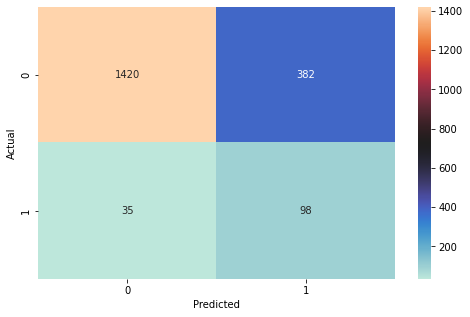

In [45]:
plot_conf_matrix(sns.color_palette("icefire", as_cmap=True))

In [46]:
def plot_roc_curve():
  # take the data in rdd format for plotting roc curve
  y_score = predictions.select(vector_to_array("probability")[1]).rdd.collect()
  y_true = predictions.select("target").rdd.collect()
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  plt.figure(figsize=(5, 5))
  plt.plot(fpr, tpr)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

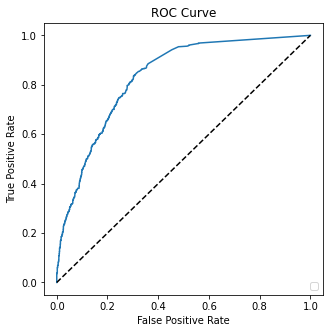

In [47]:
plot_roc_curve()

### Decision Tree

In [48]:
# training
model_dt_v = DecisionTreeClassifier(featuresCol="selectedFeatures", labelCol="target")
model_dt_v = model_dt_v.fit(train_v)
# predictions
predictions = model_dt_v.transform(validation_v)

In [49]:
compute_metrics()

{'f1': 0.7502258317686978,
 'accuracy': 0.786046511627907,
 'recallByLabel': 0.2708333333333333,
 'precisionByLabel': 0.6701030927835051}

In [50]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87      1455
         1.0       0.67      0.27      0.39       480

    accuracy                           0.79      1935
   macro avg       0.73      0.61      0.63      1935
weighted avg       0.77      0.79      0.75      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


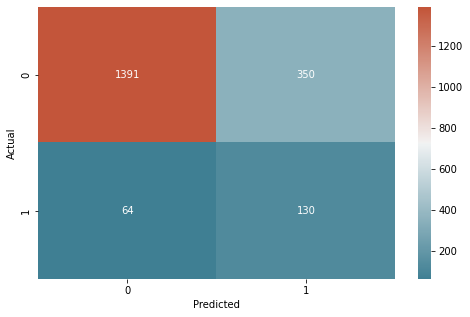

In [51]:
plot_conf_matrix(sns.diverging_palette(220, 20, as_cmap=True))

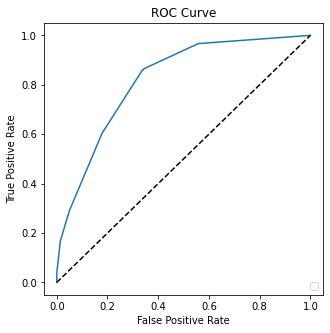

In [52]:
plot_roc_curve()

### GBDT

In [53]:
gbtc = GBTClassifier(featuresCol = 'selectedFeatures', labelCol="target", maxIter=20)
gbtc = gbtc.fit(train_v)
# prediction
predictions = gbtc.transform(validation_v)

In [54]:
compute_metrics()

{'f1': 0.7663923578537911,
 'accuracy': 0.7917312661498708,
 'recallByLabel': 0.33958333333333335,
 'precisionByLabel': 0.6546184738955824}

In [55]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.81      0.94      0.87      1455
         1.0       0.65      0.34      0.45       480

    accuracy                           0.79      1935
   macro avg       0.73      0.64      0.66      1935
weighted avg       0.77      0.79      0.77      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


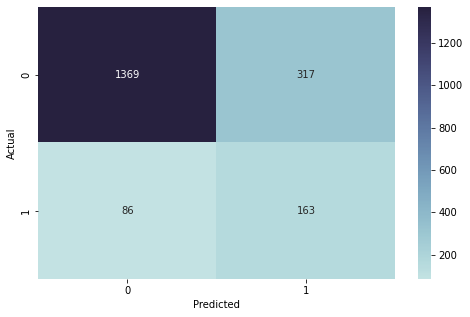

In [56]:
plot_conf_matrix(sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True))

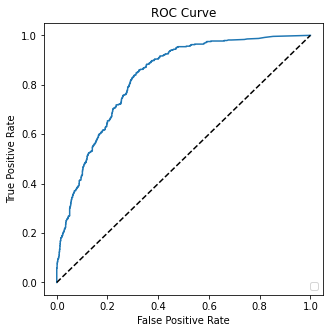

In [57]:
plot_roc_curve()

### SVM

In [58]:
svc_l = LinearSVC(featuresCol='selectedFeatures', labelCol="target", maxIter=20)
svc_l= svc_l.fit(train_v)
predictions = svc_l.transform(validation_v)

In [59]:
compute_metrics()

{'f1': 0.6483426083733964,
 'accuracy': 0.751937984496124,
 'recallByLabel': 0.00625,
 'precisionByLabel': 0.5}

In [60]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      1455
         1.0       0.50      0.01      0.01       480

    accuracy                           0.75      1935
   macro avg       0.63      0.50      0.44      1935
weighted avg       0.69      0.75      0.65      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


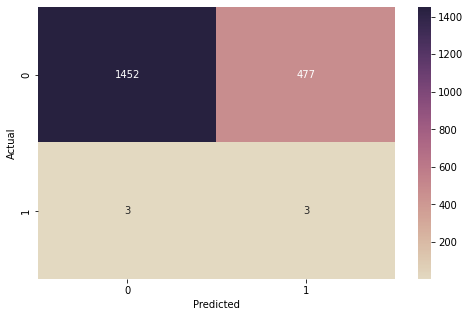

In [61]:
plot_conf_matrix(sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

In all the cases, performances are similar except in case of linear SVC. In trees classifiers, Recall and F1-score for Credit Default are never high but don't tend to 0 as for SVC. Even changing the max_iter parameter, Recall and F1score for Credit Default tend always to 0, supposing that a linear boundary is not the best case for distinguish the Credit Default. A non-linear SVC would have suited the case better but unfortunately it is not yet present in PySpark.

# Feature Selection with UnivariateFeatureSelection

In [62]:
# ChiSqSelector - Deprecated since version 3.1.0: Thus UnivariateFeatureSelector

selector = UnivariateFeatureSelector(featuresCol="features", outputCol="selectedFeatures",
                                     labelCol="target", selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

columns_final.append('selectedFeatures')

fitting = selector.fit(assembled_df)
selected_feat = fitting.selectedFeatures

result = fitting.transform(assembled_df).select(columns_final)

print("UnivariateFeatureSelector output with top %d features selected using f_classif"
      % selector.getSelectionThreshold())

UnivariateFeatureSelector output with top 20 features selected using f_classif


In [ ]:
result.take(1)

[Row(customer_ID='0014d951622647e823722b75013b52df120f9ca0f8acc57321616e6a4a1f80f7', S_2='2018-02-01', target=0.0, selectedFeatures=DenseVector([0.902, 0.091, 0.031, 1.001, 0.009, 0.213, 0.0, 0.004, 0.0, 0.0, 0.004, 0.038, 1.001, 0.006, 0.436, 0.734, 0.029, 0.0, 0.187, 0.03]))]

In [63]:
#selected explicit features
new_header = [col for col in df.columns if col not in columns_final]
sel_feat_expl = [new_header[n] for n in selected_feat]

In [64]:
# getting the distribution of the original type of variables
# e.g: D_* = Delinquency variables
#      S_* = Spend variables
#      P_* = Payment variables
#      B_* = Balance variables
#      R_* = Risk variables

orig_cdist = Counter(re.findall('\w*_', ' '.join(new_header)))

print(orig_cdist)

Counter({'D_': 96, 'B_': 40, 'R_': 28, 'S_': 21, 'P_': 3})


The original distribution of the types variables is the following:

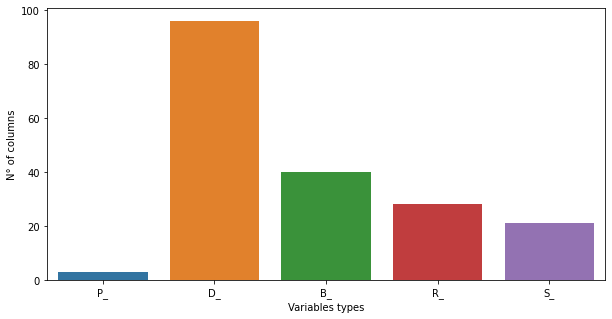

In [65]:
plt.figure(figsize=(10,5))
plt.ylabel("N° of columns")
plt.xlabel("Variables types")
sns.barplot(x=list(orig_cdist.keys()), y=list(orig_cdist.values()))

In [66]:
selected_cdist = Counter(re.findall('\w*_', ' '.join(sel_feat_expl)))

print(selected_cdist)

Counter({'D_': 10, 'B_': 6, 'R_': 2, 'P_': 1, 'S_': 1})


The distribution with the Univariate Selection Feature has more or less the same trend as before (the major variables selected are always those related to Delinquency).

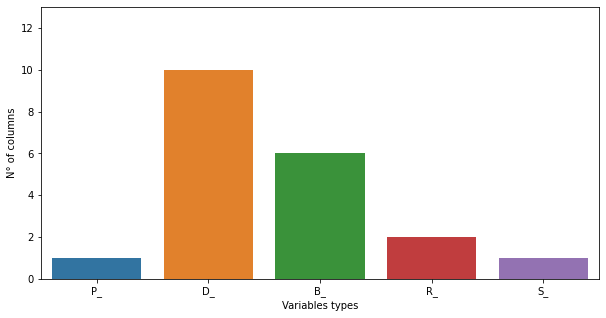

In [67]:
plt.figure(figsize=(10,5))
plt.ylabel("N° of columns")
plt.xlabel("Variables types")
plt.ylim(0,13)
sns.barplot(x=list(selected_cdist.keys()), y=list(selected_cdist.values()))

# Train-test split
Not stratified (yet to implement)

In [68]:
train, validation = result.randomSplit(weights=[0.8,0.2], seed=42)

# Random Forest

In [69]:
rf = RandomForestClassifier(labelCol="target", featuresCol="selectedFeatures", seed=42, numTrees=30)
model = rf.fit(train)

In [70]:
rf_feat_imp = model.featureImportances

In [71]:
feat_by_imp = sorted(list(zip(rf_feat_imp.indices, rf_feat_imp.toArray())), key = lambda x: -x[1])
correct_feat_by_imp = [(sel_feat_expl[tup[0]], tup[1]) for tup in feat_by_imp]

In [72]:
predictions = model.transform(validation)

In [ ]:
predictions.show()

+--------------------+----------+------+--------------------+--------------------+--------------------+----------+
|         customer_ID|       S_2|target|    selectedFeatures|       rawPrediction|         probability|prediction|
+--------------------+----------+------+--------------------+--------------------+--------------------+----------+
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|[17.5251991410550...|[0.58417330470183...|       0.0|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|[22.1281182823531...|[0.73760394274510...|       0.0|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|[24.5349586297951...|[0.81783195432650...|       0.0|
|0081622f92bc7b661...|2018-02-10|   0.0|[0.911,0.068,0.01...|[29.1650472085114...|[0.97216824028371...|       0.0|
|00be9aec004505277...|2017-03-22|   0.0|[0.608,0.004,0.03...|[23.9430346069989...|[0.79810115356663...|       0.0|
|00f1a29d193758630...|2017-10-14|   0.0|[0.998,0.008,0.03...|[29.2693243596109..

In [73]:
compute_metrics()

{'f1': 0.8447903154874403,
 'accuracy': 0.8480620155038759,
 'recallByLabel': 0.6354166666666666,
 'precisionByLabel': 0.7193396226415094}

In [74]:
ytest_ypred = classreport()
print(cr(ytest_ypred[0],ytest_ypred[1]))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      1455
         1.0       0.72      0.64      0.67       480

    accuracy                           0.85      1935
   macro avg       0.80      0.78      0.79      1935
weighted avg       0.84      0.85      0.84      1935



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


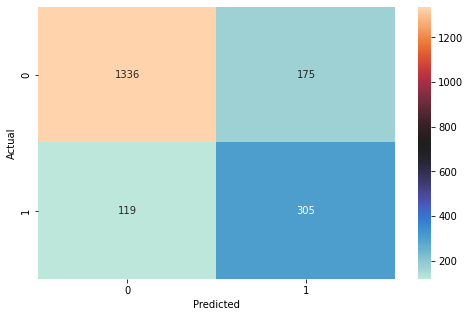

In [75]:
plot_conf_matrix(sns.color_palette("icefire", as_cmap=True))

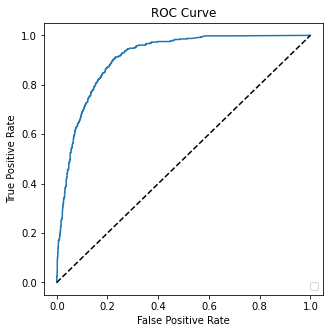

In [76]:
plot_roc_curve()

# PCA

In [ ]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

model = pca.fit(assembled_df)
pca_df = model.transform(assembled_df)

In [ ]:
pca_df.show()

+--------------------+----------+------+--------------------+--------------------+
|         customer_ID|       S_2|target|            features|        pca_features|
+--------------------+----------+------+--------------------+--------------------+
|0014d951622647e82...|2018-02-01|   0.0|[0.902,0.091,0.03...|[0.00326475286152...|
|001b8b68722cd18ec...|2017-12-09|   0.0|[0.96,0.006,0.001...|[0.00385749576992...|
|001cde1044b029fab...|2017-03-25|   1.0|[0.0,0.033,0.899,...|[0.00937803901764...|
|001ff5350ab524ad2...|2017-11-22|   1.0|[0.318,0.472,0.02...|[0.01962854750359...|
|002da05f7452c77cd...|2017-05-26|   0.0|[0.829,1.037,0.04...|[0.00516078085079...|
|0033da35db3a15c28...|2017-08-29|   1.0|[0.273,0.384,0.02...|[0.01242020267577...|
|003f7b33280fff053...|2017-11-22|   1.0|[0.528,0.008,0.00...|[0.00324598474620...|
|004f500fb6369857e...|2017-09-08|   1.0|[0.323,0.006,0.00...|[0.00750254621604...|
|005382536094338c2...|2017-09-16|   0.0|[0.281,0.031,0.04...|[0.00485650722388...|
|005

In [ ]:
sampled_pca_out = pca_df.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select('pca_features').collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])

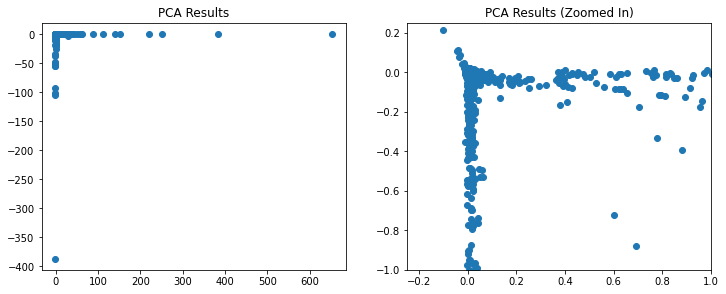

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1])

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1])
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.show()


In [ ]:
# Trains a bisecting k-means model.
bkm = BisectingKMeans().setK(2).setSeed(1)
model = bkm.fit(assembled_df.select('features'))

# Make predictions
predictions = model.transform(assembled_df.select('features'))

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.3316527680742651
Cluster Centers: 
[7.47807549e-01 1.08574966e-01 3.05660152e-02 8.65852305e-01
 2.23702820e-02 1.39453677e-01 2.33158287e-02 1.51514247e-02
 1.90232732e-02 8.22182605e-02 3.78102342e-02 8.28458899e-02
 2.75644637e-01 1.07932717e-01 1.20005967e-02 3.30117559e-01
 4.35841265e-01 1.90411010e-01 1.00026854e-02 2.01221393e-01
 8.53860958e-02 3.81827242e-01 8.78957183e-02 1.79828883e-01
 5.79107862e-02 9.92309414e-02 2.02960018e-01 5.89331195e-01
 3.03366552e-01 4.62673430e-03 5.15276742e-02 2.28206773e-02
 3.06902581e-01 9.92911532e-01 7.76771595e-03 1.35939132e-01
 1.12264061e-01 3.48744592e-01 1.63343876e-01 1.08742802e-01
 1.11034462e-01 7.36043563e-03 1.08649709e-01 3.39471878e-02
 5.78167984e-02 3.30189467e-01 3.85447113e-01 2.37389080e-01
 4.00736983e-02 3.81083992e-01 2.12907355e-01 7.26838729e-01
 2.04535283e-01 6.05698941e-02 4.92316873e-03 1.93943011e-03
 5.64970909e-01 2.41533642e-01 1.41876772e-01 4.43085186e-02
 1.

In [ ]:
cluster_pca = pca_df.join(predictions, 'features')

In [ ]:
sampled_pca_out = cluster_pca.sample(withReplacement = False, fraction = 0.99, seed = 42)
data_pca_collected = sampled_pca_out.select(['pca_features', 'prediction', 'target']).collect()
to_plot = np.array([row.pca_features.toArray() for row in data_pca_collected])
colors = np.array([row.prediction for row in data_pca_collected])
colors_true = np.array([row.target for row in data_pca_collected])

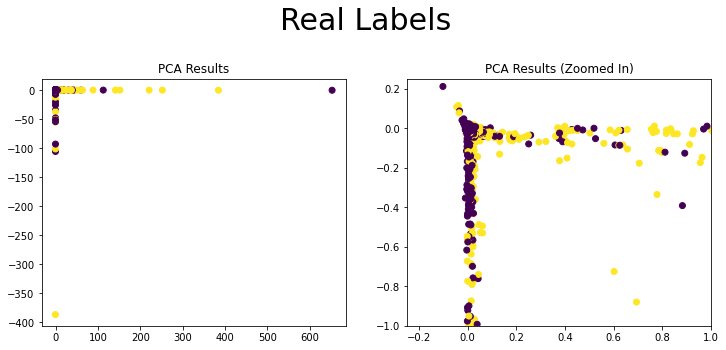

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors_true)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Real Labels', fontsize = 30)
plt.show()


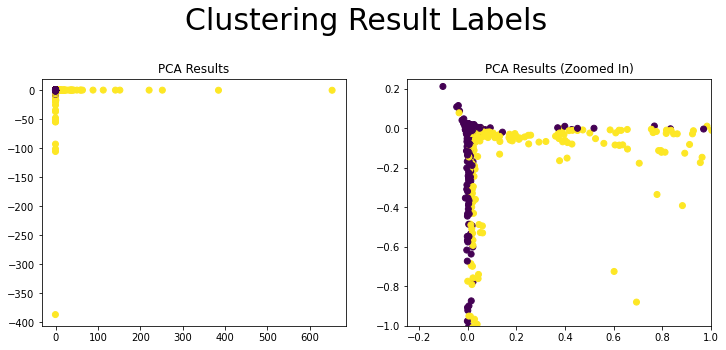

In [ ]:
plt.figure(figsize=(12, 10)) 
plt.subplot2grid((2, 2), (0, 0), title = 'PCA Results')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)

plt.subplot2grid((2, 2), (0, 1),  title = 'PCA Results (Zoomed In)')
plt.scatter(to_plot[:,0], to_plot[:,1], c = colors)
plt.xlim(-0.25, 1)
plt.ylim(-1, 0.25)
plt.suptitle('Clustering Result Labels', fontsize = 30)
plt.show()
